# Creating ADVERSARIAL Examples and Their Generalization (BLACK BOX Attack)

In [0]:
%matplotlib inline
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

download pretrained model from here:https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing

Epsilons :  List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is [0,1], no epsilon value should exceed 1.

In [0]:
#pretrained_model - path to the pretrained MNIST model.
#use_cuda - boolean flag to use CUDA if desired and available. 
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=False

Let's define our pretrained Lenet model

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

FGSM : Fast Gradient Sign Method . Here perturbation added to input is basically ϵ (epsilon - pixel-wise perturbation amount) times the sign of data_grad( gradient of the loss w.r.t the input image (∇xJ(θ,x,y)))

perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))

In [0]:
# FGSM attack code
#epsilon - pixel-wise perturbation amount (ϵ)
#data_grad - gradient of the loss w.r.t the input image (∇xJ(θ,x,y))

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

The test function reports the accuracy of a model that is under attack from an adversary with strength ϵ. This function also saves and returns some successful adversarial examples to be visualized later.

In [0]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(),adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

as epsilon increases we expect the test accuracy to decrease. This is because larger epsilons mean we take a larger step in the direction that will maximize the loss.

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


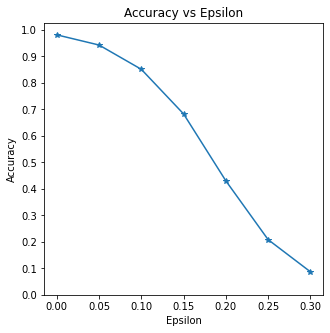

In [0]:
 plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

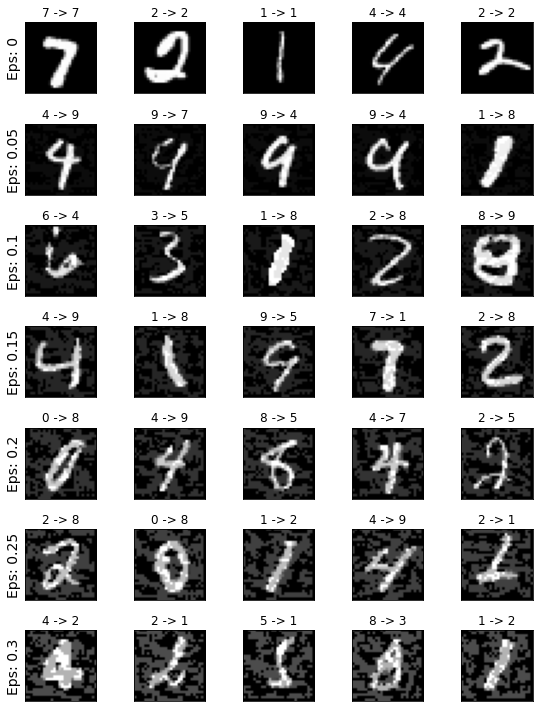

In [0]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

 As epsilon increases the test accuracy decreases BUT the perturbations become more easily perceptible. In reality, there is a tradeoff between accuracy degredation and perceptibility that an attacker must consider. Here, we show some examples of successful adversarial examples at each epsilon value. Each row of the plot shows a different epsilon value.
  
  above each img:
  
          “original classification -> adversarial classification.” 

Try these adversarial examples on any other model architecture to see
adversarial examples generated by our 1st model(Lenet) can fool any other model or not!

In [0]:
# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.006

In [0]:
# loading mnist train dataset to train the new model
# MNIST dataset 
train_dataset = datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


Let's define a simple fully connected network


In [0]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model2 = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [0]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)  


Training the model on MNIST dataset and testing it on some test images with no perturbation .

In [0]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model2.state_dict(), 'model2.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.1040
Epoch [1/5], Step [200/600], Loss: 0.2513
Epoch [1/5], Step [300/600], Loss: 0.2206
Epoch [1/5], Step [400/600], Loss: 0.0843
Epoch [1/5], Step [500/600], Loss: 0.0895
Epoch [1/5], Step [600/600], Loss: 0.1641
Epoch [2/5], Step [100/600], Loss: 0.0616
Epoch [2/5], Step [200/600], Loss: 0.1602
Epoch [2/5], Step [300/600], Loss: 0.1307
Epoch [2/5], Step [400/600], Loss: 0.1637
Epoch [2/5], Step [500/600], Loss: 0.0365
Epoch [2/5], Step [600/600], Loss: 0.1164
Epoch [3/5], Step [100/600], Loss: 0.0630
Epoch [3/5], Step [200/600], Loss: 0.0207
Epoch [3/5], Step [300/600], Loss: 0.0244
Epoch [3/5], Step [400/600], Loss: 0.1074
Epoch [3/5], Step [500/600], Loss: 0.0416
Epoch [3/5], Step [600/600], Loss: 0.0381
Epoch [4/5], Step [100/600], Loss: 0.0540
Epoch [4/5], Step [200/600], Loss: 0.0851
Epoch [4/5], Step [300/600], Loss: 0.0055
Epoch [4/5], Step [400/600], Loss: 0.0176
Epoch [4/5], Step [500/600], Loss: 0.0342
Epoch [4/5], Step [600/600], Loss:

 Plot several examples of adversarial samples at each epsilon but this time with predictions of model 2

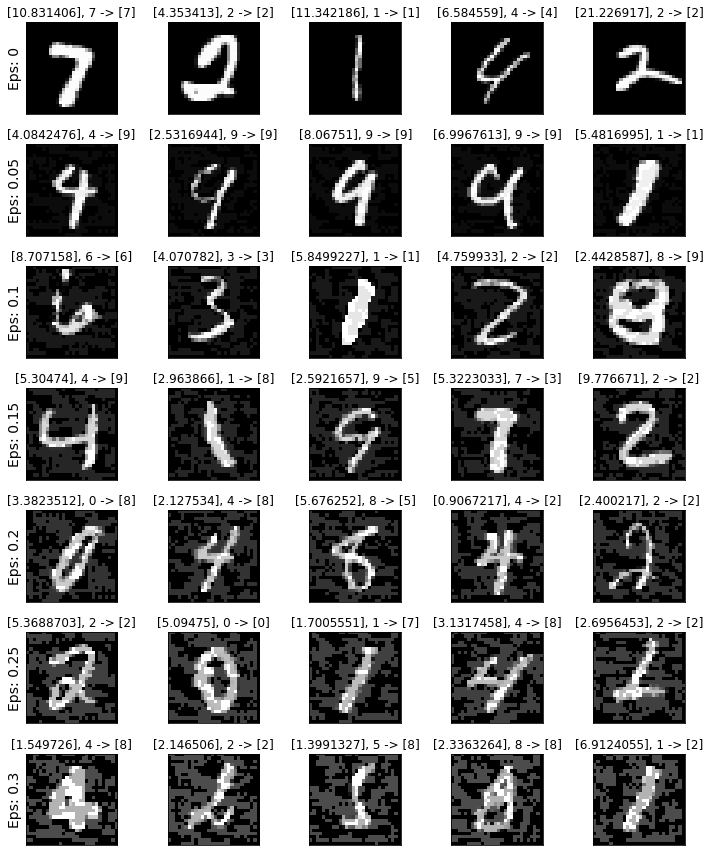

In [0]:
cnt = 0
plt.figure(figsize=(10,12))
for i in range(len(epsilons)):
  for j in range(len(examples[i])):
    cnt += 1
    plt.subplot(len(epsilons),len(examples[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
      plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
    orig,adv,ex = examples[i][j]
    plt.imshow(ex, cmap="gray")
    ex = torch.from_numpy(ex).float().reshape(-1, 28*28).to(device)
    output = model2(ex)
    confidence , predicted = torch.max(output.data, 1)
    predicted=predicted.cpu().numpy()
    confidence=confidence.cpu().numpy()
    plt.title("{}, {} -> {}".format(confidence,orig, predicted))
plt.tight_layout()
plt.show()
    

Above each image:

           CONFIDENCE,  “original classification -> adversarial classification by model2.” 

we see that adversarial examples generated by Lenet also fooled model2 also for quite bigger values of epsilon(i.e. 0.15 onwards).Also some times,it predicted same class as the Lenet prediced. This shows Generalisation of ADVERSARIAL examples.......